In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

np.random.seed(55)

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [3]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False)])

training = spark.read.option("sep", "\t").csv("../data/MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("../data/MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("../data/MovieLens.item", header=False, schema=schema_items)

In [4]:
#training = training.toPandas()
#test = test.toPandas()

In [5]:
#total = pd.concat([training,test])
#total

In [6]:
#len(total.user_id.unique())

In [7]:
#len(total.item_id.unique())

# Base Model

In [8]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
modelBefore = als.fit(training)
predictions = modelBefore.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9289072116296536

In [9]:
predBefore = predictions.toPandas()
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1861904|
|    332|    148|     5|887938486| 3.7069576|
|     44|    148|     4|878346946| 3.1629443|
|    236|    148|     4|890117028| 2.3182583|
|    222|    148|     2|881061164|  2.922283|
|    372|    148|     5|876869915| 3.6742992|
|    224|    148|     3|888104154| 3.2511005|
|      1|    148|     2|875240799|  2.674487|
|    274|    148|     2|878946133| 3.4395094|
|    178|    148|     4|882824325|  3.587033|
|    328|    148|     3|885048638| 3.1832826|
|    164|    148|     5|889402203| 3.9701242|
|    120|    148|     3|889490499|  3.075549|
|     92|    148|     2|877383934| 2.9823596|
|    447|    148|     4|878854729|  3.013447|
|     15|    148|     3|879456049| 2.8941395|
|     59|    148|     3|888203175|  3.133169|
|     49|    148|     1|888068195|  1.340607|
|    130|    148|     4|876251127|

In [10]:
userRecs = modelBefore.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

Total users with 243: 0


# Training data analysis

In [11]:
movie = training.toPandas()
movie

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [12]:
len(movie.user_id.unique())

943

In [13]:
f = movie.groupby('item_id', as_index=False).count().sort_values(by=['rating'])
f = f[f['item_id'] == 243]
f

,item_id,user_id,rating,timestamp
242,243,108,108,108


In [14]:
movie.groupby('item_id').mean().sort_values(by=['rating']).iloc[300:305]

,user_id,rating,timestamp
item_id,,,
585,525.777778,2.472222,8.842056e+08
158,462.780000,2.480000,8.811020e+08
243,528.870370,2.490741,8.841078e+08
759,537.000000,2.500000,8.813114e+08
681,555.083333,2.500000,8.842872e+08


In [15]:
movie.rating.describe()

count    80000.000000
mean         3.528350
std          1.118565
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [16]:
ratings = movie.rating.to_numpy()
ratings

array([5, 3, 4, ..., 3, 3, 3], dtype=int32)

### Original Distribution

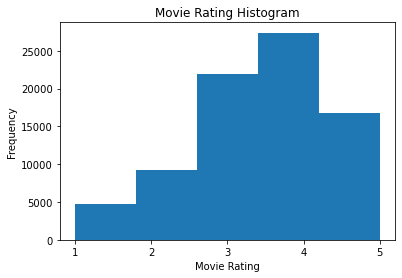

In [17]:
plt.xlabel("Movie Rating")
plt.ylabel("Frequency")
plt.title("Movie Rating Histogram")
plt.hist(movie.rating, bins=5)
plt.xticks(np.arange(1,6))
plt.show()

(array([ 5778.,  4287.,  5607.,  7057., 10490., 10454.,  9415.,  8113.,
         8795., 10004.]),
 array([  1. ,  95.2, 189.4, 283.6, 377.8, 472. , 566.2, 660.4, 754.6,
        848.8, 943. ]),
 <BarContainer object of 10 artists>)

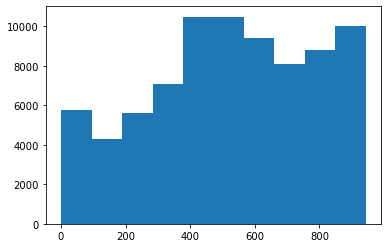

In [18]:
plt.hist(movie.user_id)

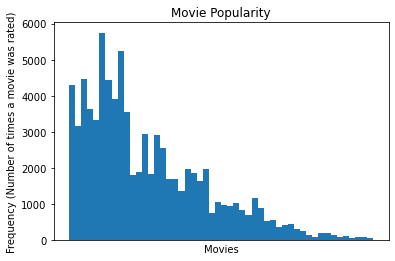

In [19]:
plt.hist(movie.item_id, bins=50)
plt.title("Movie Popularity")
plt.xlabel("Movies")
plt.ylabel("Frequency (Number of times a movie was rated)")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

(array([568., 191.,  94.,  55.,  19.,  11.,   1.,   2.,   1.,   1.]),
 array([  4. ,  72.1, 140.2, 208.3, 276.4, 344.5, 412.6, 480.7, 548.8,
        616.9, 685. ]),
 <BarContainer object of 10 artists>)

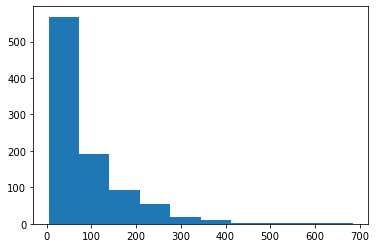

In [20]:
# Distribution of number of ratings by users
num_of_ratings = movie.groupby('user_id', as_index=False).agg({'rating':'count'}).rename(columns={'rating':'count'}).sort_values(by=['user_id'])
#num_of_ratings['count']
plt.hist(num_of_ratings['count'])

# Target items and users

In [21]:
trainDf = training.toPandas()
testDf = test.toPandas()
num_users, num_items = len(trainDf.user_id.unique()), len(trainDf.item_id.unique())
max_uid, max_iid = trainDf.user_id.unique().max(), trainDf.item_id.unique().max()
print(f'num_users: {num_users} num_items : {num_items}')
print(f'max_user_id: ', max_uid, " max_item_id: ", max_iid)

num_users: 943 num_items : 1650
max_user_id:  943  max_item_id:  1682


In [22]:
#target_items = [1580, 1581, 1577, 1583, 1570]
target_items = [868, 1162, 927, 1521, 1301, 1191]

In [23]:
NUM_SEL_ITEMS = 3
# - Create popular selected item list
item_ratings = dict(trainDf.groupby('item_id').size())
item_pop = [0] * (max_iid + 1)

for item_id in item_ratings.keys():
    item_pop[item_id] = item_ratings[item_id]
    
items_sorted = np.array(item_pop).argsort()[::-1]
selected_items = items_sorted[:NUM_SEL_ITEMS]
print("selected_items: ", selected_items)

selected_items:  [ 50 181 258]


In [24]:
# - create target users  
def getTargetUsers(targetItems):
    users_rated_target = set(trainDf[trainDf.item_id.isin(targetItems)].user_id.values)
    # - Users who have not rated target item
    data_tmp = trainDf[~trainDf.user_id.isin(users_rated_target)].copy()
    #data_tmp = data_tmp[data_tmp.rating >= threshold]

    # - Users who have not rated target item and have rated selected_items
    target_users = data_tmp[data_tmp.item_id.isin(selected_items)].groupby('user_id').size()
    
    #print("Number of target users: ", target_users[(target_users == NUM_SEL_ITEMS)].shape[0])
    target_users = sorted(target_users.index)
    return target_users
target_users = getTargetUsers(target_items)
print("target_users: ", len(target_users))

target_users:  674


# Generate the random ratings from the global distribution

# New Random attack with 50 user profiles

In [25]:
# Generate 50 user_ids
number_of_ids = 50
starting_id = 1000
new_user_ids = np.arange(starting_id, starting_id+number_of_ids)

In [26]:
# Get list of number of ratings for the 50 users
def get_num_of_ratings(num_of_ratings, add_noise = True):
    num_of_ratings_list = num_of_ratings['count'].sample(n=number_of_ids, random_state=1, replace=True).to_numpy()
    if add_noise:
        x = np.arange(-10, 11)
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
        prob = prob / prob.sum() # normalize the probabilities so their sum is 1
        nums = np.random.choice(x, size = 50, p = prob)
        num_of_ratings_list = num_of_ratings_list + nums
    return num_of_ratings_list


In [27]:
def generate_sample_attack(new_user_ids, num_of_ratings_list, target_item = []):
    if len(new_user_ids) != len(num_of_ratings_list):
        raise Exception()
    
    
    attack_df = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])
    for i in range(len(new_user_ids)):
        user_id = new_user_ids[i]
        num_of_ratings = num_of_ratings_list[i]
        
        random_movies = movie['item_id'].sample(n=num_of_ratings, random_state=3).to_numpy()
        random_ratings = movie['rating'].sample(n=num_of_ratings, random_state=55, replace=True).to_numpy()
        
        for j in range(num_of_ratings):
            if(random_movies[j] not in target_item):
                attack_df.loc[len(attack_df.index)] = [user_id, random_movies[j], random_ratings[j]] 
        
        for item in target_item:
            attack_df.loc[len(attack_df.index)] = [user_id, item, 5]
    
    return attack_df



In [28]:
num_of_ratings_list = get_num_of_ratings(num_of_ratings, add_noise=False)
attack_df = generate_sample_attack(new_user_ids, num_of_ratings_list)
attack_df

,user_id,item_id,rating
0,1000,190,5
1,1000,802,4
2,1000,524,5
3,1000,951,3
4,1000,73,3
...,...,...,...
4213,1049,27,3
4214,1049,778,5
4215,1049,931,5
4216,1049,194,5


In [29]:
attack = pd.concat([movie, attack_df]).sort_values(by=['user_id', 'item_id'])
attack

,user_id,item_id,rating,timestamp
0,1,1,5,874965758.0
1,1,2,3,876893171.0
2,1,3,4,878542960.0
3,1,4,3,876893119.0
4,1,5,3,889751712.0
...,...,...,...,...
4199,1049,1162,2,NaN
4169,1049,1210,4,NaN
4094,1049,1313,3,NaN
4089,1049,1401,1,NaN


In [30]:
attackedDF = spark.createDataFrame(attack)
attackedDF

DataFrame[user_id: bigint, item_id: bigint, rating: bigint, timestamp: double]

### Random Attack with no target item

In [31]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9310794384729507

In [32]:
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1616752|
|    332|    148|     5|887938486| 3.7175038|
|     44|    148|     4|878346946| 3.1636636|
|    236|    148|     4|890117028| 2.3607836|
|    222|    148|     2|881061164|  2.949143|
|    372|    148|     5|876869915|  3.727017|
|    224|    148|     3|888104154|  3.234154|
|      1|    148|     2|875240799| 2.6497324|
|    274|    148|     2|878946133|   3.48087|
|    178|    148|     4|882824325| 3.5990753|
|    328|    148|     3|885048638| 3.1706047|
|    164|    148|     5|889402203| 3.8963923|
|    120|    148|     3|889490499| 3.1161685|
|     92|    148|     2|877383934|  2.977059|
|    447|    148|     4|878854729| 3.0014522|
|     15|    148|     3|879456049| 2.9059622|
|     59|    148|     3|888203175| 3.1267412|
|     49|    148|     1|888068195| 1.3492426|
|    130|    148|     4|876251127|

In [33]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

Total users with 243: 0


In [34]:
def get_n_recommendations(predictions, n=10):
    p = predictions.sort_values(by=['user_id', 'prediction'], ascending=[True, False])
    p2 = p.groupby('user_id')['item_id'].apply(list).reset_index(name='movies')
    p2['movies'] = p2['movies'].apply(lambda l: l[:n])
    return p2

def get_occurences(top_rec, target_item):
    t = top_rec['movies'].to_numpy()
    count = 0
    for i in t:
        for j in i:
            if j == target_item:
                count += 1
    return count

In [35]:
top_10 = get_n_recommendations(predictions.toPandas(), n=10)
top_10

,user_id,movies
0,1,"[98, 134, 64, 171, 174, 12, 100, 189, 190, 183]"
1,2,"[251, 19, 50, 313, 315, 316, 297, 292, 303, 298]"
2,3,"[272, 318, 345, 327, 307, 337, 324, 354, 334, ..."
3,4,"[357, 50, 361, 303, 354, 294, 288, 260, 264, 356]"
4,5,"[173, 89, 176, 100, 1, 445, 109, 222, 79, 144]"
...,...,...
454,457,"[443, 192, 182, 636, 708, 366, 704, 775]"
455,458,"[1101, 648, 144]"
456,459,[934]
457,460,[10]


In [36]:
get_occurences(top_10, 243)

5

### Attack with target item 243

In [37]:
attack_df = generate_sample_attack(new_user_ids, num_of_ratings_list, target_item=[243])
attack = pd.concat([movie, attack_df]).sort_values(by=['user_id', 'item_id'])
attackedDF = spark.createDataFrame(attack)

In [38]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.931017956818702

In [39]:
predictions.show()

+-------+-------+------+---------+----------+
|user_id|item_id|rating|timestamp|prediction|
+-------+-------+------+---------+----------+
|    251|    148|     2|886272547| 3.1732752|
|    332|    148|     5|887938486|  3.717844|
|     44|    148|     4|878346946| 3.1718524|
|    236|    148|     4|890117028| 2.3460917|
|    222|    148|     2|881061164| 2.9492538|
|    372|    148|     5|876869915| 3.7240727|
|    224|    148|     3|888104154| 3.2367597|
|      1|    148|     2|875240799| 2.6556787|
|    274|    148|     2|878946133|  3.475436|
|    178|    148|     4|882824325|  3.603771|
|    328|    148|     3|885048638|  3.172769|
|    164|    148|     5|889402203| 3.9102132|
|    120|    148|     3|889490499| 3.0954247|
|     92|    148|     2|877383934|  2.996205|
|    447|    148|     4|878854729| 3.0121357|
|     15|    148|     3|879456049|   2.92254|
|     59|    148|     3|888203175| 3.1321208|
|     49|    148|     1|888068195| 1.3358644|
|    130|    148|     4|876251127|

In [40]:
top_10 = get_n_recommendations(predictions.toPandas(), n=10)
top_10

,user_id,movies
0,1,"[98, 134, 64, 171, 174, 12, 100, 189, 190, 183]"
1,2,"[251, 19, 50, 313, 315, 316, 297, 292, 303, 298]"
2,3,"[272, 318, 345, 307, 327, 337, 324, 331, 354, ..."
3,4,"[357, 50, 361, 303, 354, 294, 288, 260, 264, 356]"
4,5,"[173, 89, 176, 100, 1, 445, 109, 222, 79, 144]"
...,...,...
454,457,"[443, 192, 182, 636, 708, 366, 704, 775]"
455,458,"[1101, 648, 144]"
456,459,[934]
457,460,[10]


In [41]:
get_occurences(top_10, 243)

5

In [42]:
userRecs = model.recommendForAllUsers(10)
userRecs = userRecs.toPandas()

target_item = 243
count = 0
for index, row in userRecs.iterrows():
    recommendations = [r['item_id'] for r in row['recommendations']]
    if target_item in recommendations:
        print(row['user_id'], recommendations)
        count += 1
print(f'Total users with {target_item}: {count}')

1025 [524, 128, 190, 945, 162, 272, 443, 243, 321, 151]
1005 [524, 190, 272, 128, 162, 443, 151, 243, 321, 945]
1016 [524, 190, 443, 162, 151, 272, 243, 128, 945, 321]
1031 [190, 524, 162, 443, 272, 151, 243, 128, 321, 945]
1030 [524, 128, 190, 162, 243, 443, 945, 272, 321, 151]
1034 [524, 190, 128, 162, 443, 243, 272, 321, 151, 945]
1019 [190, 524, 162, 443, 272, 151, 321, 243, 128, 945]
1046 [524, 128, 190, 162, 443, 243, 272, 945, 321, 151]
1047 [524, 190, 443, 162, 272, 151, 128, 243, 945, 512]
1021 [524, 190, 272, 128, 162, 443, 151, 243, 321, 945]
1026 [524, 190, 443, 151, 162, 272, 243, 128, 945, 512]
1028 [190, 524, 443, 162, 151, 272, 243, 128, 945, 321]
1029 [190, 524, 443, 162, 151, 272, 128, 243, 945, 321]
1002 [524, 190, 443, 162, 272, 151, 128, 243, 945, 512]
1048 [524, 190, 443, 151, 162, 272, 243, 128, 945, 512]
1035 [524, 128, 190, 162, 945, 272, 443, 243, 321, 615]
1045 [524, 190, 443, 151, 243, 272, 162, 128, 945, 321]
1017 [190, 524, 443, 162, 151, 272, 128, 243, 94

### Attack with target item [1580 1581 1577 1583 1570]

In [43]:
attack_df = generate_sample_attack(new_user_ids, num_of_ratings_list, target_item=target_items)
attack = pd.concat([movie, attack_df]).sort_values(by=['user_id', 'item_id'])
attackedDF = spark.createDataFrame(attack)

In [44]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

0.9310191905481484

##### Prediction Shift

In [45]:
def prediction_shift(predBefore, predAtk, target_users, testDf):
    
    targetUsersTest = testDf[testDf.user_id.isin(target_users)]
    numTargetUsersInTest = len(targetUsersTest.user_id.unique())
    print(f'Number of target users in test: {numTargetUsersInTest}')
    
    # - Prediction shift across targetted users
    predAttackTargetUser = predAtk[predAtk.user_id.isin(target_users)].sort_values(['user_id', 'item_id']).prediction
    predTargetUser = predBefore[predBefore.user_id.isin(target_users)].sort_values(['user_id', 'item_id']).prediction
    targetUserPredShift = np.sum(predAttackTargetUser - predTargetUser)/numTargetUsersInTest
    
    predAfterAttack = predAtk.sort_values(['user_id', 'item_id']).prediction
    predBeforeAttack = predBefore.sort_values(['user_id', 'item_id']).prediction
    allUsersPredShift = np.sum(predAfterAttack - predBeforeAttack)/len(testDf.user_id.unique())
    
    return (allUsersPredShift, targetUserPredShift)

In [46]:
predAtk = predictions.toPandas()

allUsersPredShift, targetUserPredShift = prediction_shift(predBefore, predAtk, target_users, testDf)

Number of target users in test: 296


In [47]:
print("Prediction shift - Target users: ", targetUserPredShift)
print("Prediction shift - All users: ", allUsersPredShift)

Prediction shift - Target users:  0.035557901537096176
Prediction shift - All users:  -0.00015769441143360013


##### Hit Ratio

In [48]:
def getTopNRecommendations(test_model, testUserIds, n=10):
    recommendations = {}
    userRecs = test_model.recommendForAllUsers(10)
    userRecs = userRecs.toPandas()
    for index, row in userRecs.iterrows():
        if row['user_id'] in testUserIds:
            userRec = [r['item_id'] for r in row['recommendations']]
            recommendations[row['user_id']] = userRec 
    return recommendations

def filterRecsByTargetItem(recommendations, targetItems):
    recWithTargetItems = {}
    for user_id in recommendations.keys():
        topNRec = recommendations[user_id]
        is_target_item_present = any(item in topNRec for item in targetItems)
        if is_target_item_present:
            recWithTargetItems[user_id] = topNRec
            #print(user_id, topNRec)
    
    return recWithTargetItems

In [49]:
testUserIds = testDf.user_id.unique()
len(testUserIds)

459

In [50]:
testUserIds = testDf.user_id.unique()
topNRecAllUsersAtk = getTopNRecommendations(model, testUserIds)
topNRecAllUsersWithTargets = filterRecsByTargetItem(topNRecAllUsersAtk, target_items)
print(f'Number of users with targets: {len(topNRecAllUsersWithTargets)}')

Number of users with targets: 7


In [51]:
topNRecAllUsersB4 = getTopNRecommendations(modelBefore, testUserIds)
topNRecAllUsersWithTargetsB4 = filterRecsByTargetItem(topNRecAllUsersB4, target_items)
print(f'Number of users with targets before attack: {len(topNRecAllUsersWithTargetsB4)}')

Number of users with targets before attack: 2


In [52]:
def getHitRatioPerItem(topNRecAllUsers, targetItems):
    hitRatioAllItems = {}
    
    for item in targetItems:
        usersWithItem = 0
        for user in topNRecAllUsers.keys():
            if item in topNRecAllUsers[user]:
                usersWithItem += 1
        hitRatio_i = usersWithItem/(len(topNRecAllUsers.keys()) * 1.0)
        hitRatioAllItems[item] = hitRatio_i
                                    
    return hitRatioAllItems 

def getAvgHitRatio(hitRatioPerItem):
    sumHitRatio = 0
    for hitRatio_i in hitRatioPerItem.values():
        sumHitRatio += hitRatio_i 
    return sumHitRatio/(len(hitRatioPerItem.keys()) * 1.0)

In [53]:
hitRatioPerItem = getHitRatioPerItem(topNRecAllUsersAtk, target_items)
print("hitRatioPerItem: ", hitRatioPerItem)
avgHitRatio = getAvgHitRatio(hitRatioPerItem)
print("\navgHitRatio after attack: ", avgHitRatio)

hitRatioPerItem:  {868: 0.0, 1162: 0.0, 927: 0.006535947712418301, 1521: 0.0, 1301: 0.0, 1191: 0.013071895424836602}

avgHitRatio after attack:  0.0032679738562091504


### 1000 Generated (TRASH)

In [ ]:
injections = 10000
# 50 user profiles
# Generate according to the distribution

In [ ]:
random_ratings = movie['rating'].sample(n=injections, random_state=1, replace=True).to_numpy()
#random_ratings

In [ ]:
plt.hist(random_ratings)

In [ ]:
random_users = movie['user_id'].sample(n=injections, random_state=2, replace=True).to_numpy()
#random_users

In [ ]:
plt.hist(random_users)

In [ ]:
random_movies = movie['item_id'].sample(n=injections, random_state=3).to_numpy()
#random_movies

In [ ]:
plt.hist(random_movies)

In [ ]:
attack_1000 = pd.DataFrame({'user_id': random_users, 'item_id': random_movies, 'rating': random_ratings})
attack_1000

In [ ]:
attack = pd.concat([movie, attack_1000]).sort_values(by=['user_id', 'item_id'])
attack

In [ ]:
attackedDF = spark.createDataFrame(attack)
attackedDF

# Evaluate based on the random attack

In [ ]:
# 0.1
als = ALS(maxIter=10, rank=100, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating", coldStartStrategy="drop")
model = als.fit(attackedDF)
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
rmse

RMSE is basically the same..

In [ ]:
predictions.show()